In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/test-file/tested.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Step 1: Dataset Description
         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

Step 2: Cleaned Data
   survived  pclass       age  sibsp  parch      fare  sex_male
0         0       3 -0.592481      1      0 -0.502445      True
1         1       1  0.638789      1      0  0.786845     False
2         1       3 -0.284663      0      0 -0.488854   

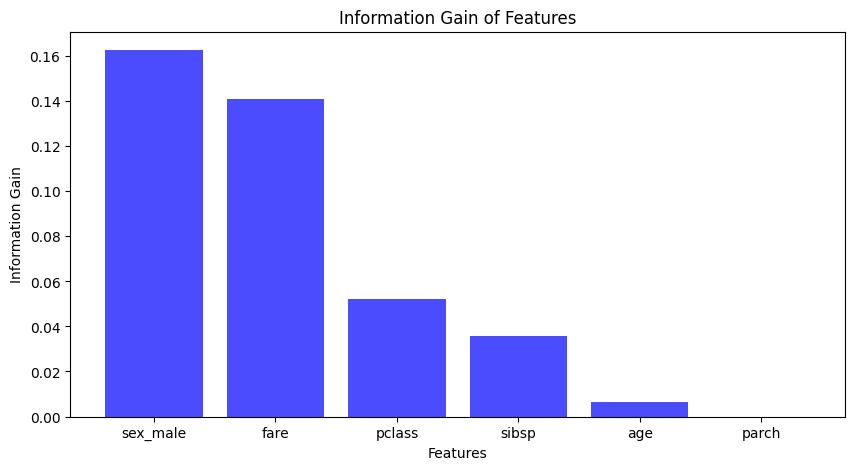

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

# Load the Titanic dataset
titanic = sns.load_dataset('titanic')

# Step 1: Short description using corresponding statistical indicators
print("Step 1: Dataset Description")
print(titanic.describe())

# Step 2: Clean the data
# Drop unnecessary features
titanic_cleaned = titanic.drop(['embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone', 'deck'], axis=1)

# Handling missing values (for simplicity, filling missing age values with the mean)
titanic_cleaned['age'].fillna(titanic_cleaned['age'].mean(), inplace=True)

# Convert categorical variables to numerical (for simplicity, using get_dummies for 'sex' feature)
titanic_cleaned = pd.get_dummies(titanic_cleaned, columns=['sex'], drop_first=True)

# Standardize the data
scaler = StandardScaler()
titanic_cleaned[['age', 'fare']] = scaler.fit_transform(titanic_cleaned[['age', 'fare']])

print("\nStep 2: Cleaned Data")
print(titanic_cleaned.head())

# Step 3: Measure information gain
X = titanic_cleaned.drop('survived', axis=1)
y = titanic_cleaned['survived']

information_gain = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
information_gain_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': information_gain}).sort_values(by='Information Gain', ascending=False)
print("\nStep 3: Information Gain of each feature")
print(information_gain_df)

# Step 4: Build a classification model using K-NN
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate K-NN model with different configurations
def evaluate_knn(features, k_value, metric):
    knn = KNeighborsClassifier(n_neighbors=k_value, metric=metric)
    knn.fit(X_train[features], y_train)
    y_pred = knn.predict(X_test[features])
    precision = precision_score(y_test, y_pred)
    return precision

# (a) Test different number of features
feature_combinations = [['age', 'fare'], ['age', 'fare', 'sex_male']]
for features in feature_combinations:
    precision_result = evaluate_knn(features, k_value=5, metric='euclidean')
    print(f"\n(a) Features: {features}, Precision: {precision_result}")

# (b) Test different number of K
k_values = [3, 5, 7]
for k_value in k_values:
    precision_result = evaluate_knn(['age', 'fare', 'sex_male'], k_value=k_value, metric='euclidean')
    print(f"\n(b) K-Value: {k_value}, Precision: {precision_result}")

# (c) Test different similarity measures
metrics = ['euclidean', 'manhattan']
for metric in metrics:
    precision_result = evaluate_knn(['age', 'fare', 'sex_male'], k_value=5, metric=metric)
    print(f"\n(c) Metric: {metric}, Precision: {precision_result}")

# Visualize and interpret results
# For simplicity, you may use a bar plot to compare precision results for different configurations.
plt.figure(figsize=(10, 5))
plt.bar(information_gain_df['Feature'], information_gain_df['Information Gain'], color='blue', alpha=0.7)
plt.title('Information Gain of Features')
plt.xlabel('Features')
plt.ylabel('Information Gain')
plt.show()
